# An Initial Analysis of the Dataset
---
After writing a simple program to process the 13 binetflow files a summary of each file and their labeled flows as well as the total flows was produced. This is the same table as theone provided by the CTU-13 dataset webpage.

However there were some slight discrepencies between my summary and the existing summary.


### Reproduced Summary
|Scen.|Total Flows|Botnet Flows|Normal Flows|C&C Flows|Background Flows|
|---|---|---|---|---|---|
|1|2824636|40961(1.45%)|30387(1.08%)|341(0.01%)|2753288(97.47%)|
|2|1808122|20941(1.16%)|9120(0.50%)|673(0.04%)|1778061(98.34%)|
|3|4710638|26822(0.57%)|116887(2.48%)|63(0.00%)|4566929(96.95%)|
|4|129832|901(0.69%)|4679(3.60%)|24(0.02%)|124252(95.70%)|
|5|1925149|40003(2.08%)|31939(1.66%)|536(0.03%)|1853207(96.26%)|
|6|1121076|2580(0.23%)|25268(2.25%)|52(0.00%)|1093228(97.52%)|
|7|114077|63(0.06%)|1677(1.47%)|26(0.02%)|112337(98.47%)|
|8|2954230|6127(0.21%)|72822(2.47%)|1074(0.04%)|2875281(97.33%)|
|9|558919|4630(0.83%)|7494(1.34%)|199(0.04%)|546795(97.83%)|
|10|2087508|184987(8.86%)|29967(1.44%)|2973(0.14%)|1872554(89.70%)|
|11|107251|8164(7.61%)|2718(2.53%)|2(0.00%)|96369(89.85%)|
|12|1309791|106352(8.12%)|15847(1.21%)|33(0.00%)|1187592(90.67%)|
|13|325471|2168(0.67%)|7628(2.34%)|25(0.01%)|315675(96.99%)|

### Original CTU-13 Summary
![CTU-13 Dataset Summary](http://mcfp.weebly.com/uploads/1/1/2/3/11233160/7883961.jpg?728)

---

It can be seen that there are some slight discrepencies between the flow values and their percentages. They may be negligible in the long run. 

The code I used to produce the summary can be found [here](https://github.com/corysabol/binetflow-botnet-detect/blob/master/src/sample.py).

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import datetime as dt
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Sample of the data
---

In [3]:
dataset_path = os.path.join('..','CTU-13-Dataset')
directory = os.fsencode(dataset_path)

files = os.listdir(directory)
sample_file = files[0]

# read the file with pandas
df = pd.read_csv(os.path.join(directory, sample_file).decode('utf-8'), low_memory=False)
#sample_df[sample_df.Label.str.contains("Botnet")].head(10)
# reindex based on StartTime
# but first drop the ns off the time stamps
df['StartTime'] = df['StartTime'].apply(lambda x: x[:19])
df['StartTime'] = pd.to_datetime(df['StartTime'])
df = df.set_index('StartTime')

In [4]:
# replace NaN with a negative port number
df['Dport'] = df['Dport'].fillna('-1')
df['Dport'] = df['Dport'].apply(lambda x: int(x,0))
df['Sport'] = df['Sport'].fillna('-1')
df['Sport'] = df['Sport'].apply(lambda x: int(x,0))

In [5]:
df.head()

,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
StartTime,,,,,,,,,,,,,,
2011-08-10 09:46:59,1.026539,tcp,94.44.127.113,1577,->,147.32.84.59,6881,S_RA,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT
2011-08-10 09:47:00,1.009595,tcp,94.44.127.113,1577,->,147.32.84.59,6881,S_RA,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT
2011-08-10 09:47:48,3.056586,tcp,147.32.86.89,4768,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
2011-08-10 09:47:48,3.111769,tcp,147.32.86.89,4788,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
2011-08-10 09:47:48,3.083411,tcp,147.32.86.89,4850,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt


### Take a look at the distribution of the data
---
We want to grab 1 second intervals of flows and extract the features of each interval, and
produce a new DataFrame whose columns are our features and rows are the results of computing the
features on each 1s time interval.

### The features

|Features|
|:-------------------|:----------------------|
|0  n_dports>1024    |1 background_flow_count|
|2  n_s_a_p_address  |3 avg_duration         |
|4  n_s_b_p_address  |5 n_sports<1024        |
|6  n_sports>1024    |7 n_conn               |
|8  n_s_na_p_address |9 n_udp                |
|10 n_icmp           |11 n_d_na_p_address    |
|12 n_d_a_p_address  |13 n_s_c_p_address     |
|14 n_d_c_p_address  |15 normal_flow_count   |
|16 n_dports<1024    |17 n_d_b_p_address     |
|18 n_tcp            |19 n_ipv6              |

We may also want to look at the number of ipv6 address

#### An aside:
We have to be able to classify ip addresses as a part of feature extraction. Below is a handy table
which lists information about classificaitons A, B, and C.

|Class   |         |           |             |Num Networks        |Hosts per network    |
|:-------|:--------|:----------|:------------|:-------------------|:--------------------|
|A       |1 – 126$*$ |0 N.H.H.H  |255.0.0.0    |126 (2^7 – 2)       | 16,777,214 (224 – 2)|
|B       |128 – 191|10 N.N.H.H |255.255.0.0  |16,382 (2^14 – 2)   | 65,534 (216 – 2)    |
|C       |192 – 223|110 N.N.N.H|255.255.255.0|2,097,150 (2^21 – 2)| 254 (28 – 2)        |

In [6]:
from functools import reduce
import ipaddress

def classify_ip(ip):
    '''
    str ip - ip address string to attempt to classify.
    treat ipv6 addresses as N/A
    '''
    try: 
        ip_addr = ipaddress.ip_address(ip)
        if isinstance(ip_addr,ipaddress.IPv6Address):
            return 'ipv6'
        elif isinstance(ip_addr,ipaddress.IPv4Address):
            # split on .
            octs = ip_addr.exploded.split('.')
            if 0 < int(octs[0]) < 127: return 'A'
            elif 127 < int(octs[0]) < 192: return 'B'
            elif 191 < int(octs[0]) < 224: return 'C'
            else: return 'N/A'
    except ValueError:
        return 'N/A'
    
def avg_duration(x):
    return np.average(x)
    
def n_dports_gt1024(x):
    if x.size == 0: return 0
    return reduce((lambda a,b: a+b if b>1024 else a),x)
n_dports_gt1024.__name__ = 'n_dports>1024'

def n_dports_lt1024(x):
    if x.size == 0: return 0
    return reduce((lambda a,b: a+b if b<1024 else a),x)
n_dports_lt1024.__name__ = 'n_dports<1024'

def n_sports_gt1024(x):
    if x.size == 0: return 0
    return reduce((lambda a,b: a+b if b>1024 else a),x)
n_sports_gt1024.__name__ = 'n_sports>1024'

def n_sports_lt1024(x):
    if x.size == 0: return 0
    return reduce((lambda a,b: a+b if b<1024 else a),x)
n_sports_lt1024.__name__ = 'n_sports<1024'

def label_atk_v_norm(x):
    for l in x:
        if 'Botnet' in l: return 'Attack'
    return 'Normal'
label_atk_v_norm.__name__ = 'label'

def background_flow_count(x):
    count = 0
    for l in x:
        if 'Background' in l: count += 1
    return count

def normal_flow_count(x):
    if x.size == 0: return 0
    count = 0
    for l in x:
        if 'Normal' in l: count += 1
    return count

def n_conn(x):
    return x.size

def n_tcp(x):
    count = 0
    for p in x: 
        if p == 'tcp': count += 1
    return count
    
def n_udp(x):
    count = 0
    for p in x: 
        if p == 'udp': count += 1
    return count
    
def n_icmp(x):
    count = 0
    for p in x: 
        if p == 'icmp': count += 1
    return count

def n_s_a_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'A': count += 1
    return count
    
def n_d_a_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'A': count += 1
    return count

def n_s_b_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'B': count += 1
    return count

def n_d_b_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'A': count += 1
    return count
        
def n_s_c_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'C': count += 1
    return count
    
def n_d_c_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'C': count += 1
    return count
        
def n_s_na_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'N/A': count += 1
    return count
    
def n_d_na_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'N/A': count += 1
    return count

def n_ipv6(x):
    count = 0
    for i in x:
        if classify_ip(i) == 'ipv6': count += 1
    return count
    

# The datastructure to hold our feature extraction funcitons, which will
# get applied to each aggregation of the datasets.
extractors = {
    'Label'   : [label_atk_v_norm,
                 background_flow_count,
                 normal_flow_count,
                 n_conn,
                ],
    'Dport'   : [n_dports_gt1024,
                 n_dports_lt1024
                ],
    'Sport'   : [n_sports_gt1024,
                 n_sports_lt1024,
                ],
    'Dur'     : [avg_duration,
                ],
    'SrcAddr' : [n_s_a_p_address,
                 n_s_b_p_address,
                 n_s_c_p_address,
                 n_s_na_p_address,
                 n_ipv6,
                ],
    'DstAddr' : [n_d_a_p_address,
                 n_d_b_p_address,
                 n_d_c_p_address,
                 n_d_na_p_address,
                 n_ipv6,
                ],
    'Proto'   : [n_tcp,
                 n_icmp,
                 n_udp,
                ],
}
    
#df.groupby(['StartTime', pd.Grouper(freq='1S')]).agg(extractors)
r = df.resample('1S')
n_df = r.agg(extractors)

C:\Users\datasoup\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\datasoup\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
n_df.columns = n_df.columns.droplevel(0) # get rid of the heirarchical columns
n_df.head()

,label,background_flow_count,normal_flow_count,n_conn,n_dports>1024,n_dports<1024,n_sports>1024,n_sports<1024,avg_duration,n_s_a_p_address,...,n_s_na_p_address,n_ipv6,n_d_a_p_address,n_d_b_p_address,n_d_c_p_address,n_d_na_p_address,n_ipv6,n_tcp,n_icmp,n_udp
StartTime,,,,,,,,,,,,,,,,,,,,,
2011-08-10 09:46:53,Normal,298,1,299,4158204,26844,8706494,50860,1410.693227,101,...,0,0,61,61,22,1,0,114,2,181
2011-08-10 09:46:54,Normal,240,5,245,3468349,23393,7343708,65873,1375.086988,80,...,1,0,61,61,16,1,0,69,3,169
2011-08-10 09:46:55,Normal,216,0,216,3014731,20808,6745607,15817,1171.472933,86,...,0,0,33,33,16,0,0,65,9,141
2011-08-10 09:46:56,Normal,250,1,251,3216015,29740,8483089,60187,1187.642413,72,...,0,0,67,67,16,0,0,86,5,158
2011-08-10 09:46:57,Normal,179,3,182,2497448,8220,5455540,52301,1356.934201,72,...,0,0,31,31,7,0,0,49,2,131


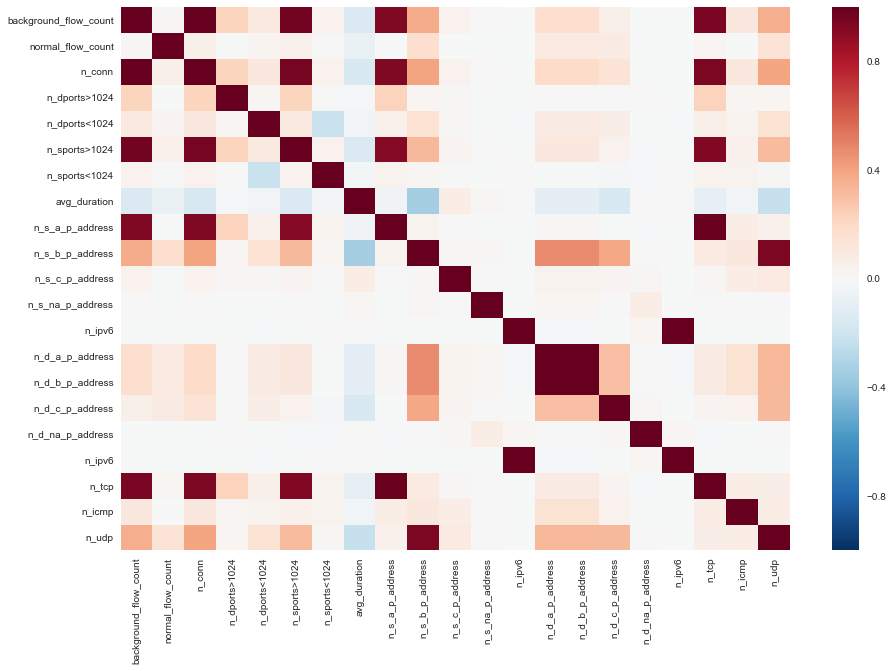

In [10]:
corr = n_df.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr,
            #cmap = sns.diverging_palette(220, 10, as_cmap=True),
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            ax=ax)

## Generate the other heatmaps
---
In order to generate a heatmap for all 13 of the files, we took the logic defined above in this notebook and
put it into it's own python file. Then iterated over each of the files, producing an aggregated dataframe on the features and a heatmap of the correlation for each file. 

These heatmaps can be seen below or [here](../plots/).

#### 00
![heatmap0](../plots/hm0.png)
#### 01
![heatmap1](../plots/hm1.png)
#### 02
![heatmap2](../plots/hm2.png)
#### 03
![heatmap3](../plots/hm3.png)
#### 04
![heatmap4](../plots/hm4.png)
#### 05
![heatmap5](../plots/hm5.png)
#### 06
![heatmap6](../plots/hm6.png)
#### 07
![heatmap7](../plots/hm7.png)
#### 08
![heatmap8](../plots/hm8.png)
#### 09
![heatmap9](../plots/hm9.png)
#### 10
![heatmap10](../plots/hm10.png)
#### 11
![heatmap11](../plots/hm11.png)
#### 12
![heatmap12](../plots/hm12.png)

